<a href="https://colab.research.google.com/github/alexfc14/fancy-neural-networks/blob/master/mask_vs_not_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building an Interpretable Face Mask Classifier

Labels: scraping, few_shot_learning, 
knowledge_transfer, 
interpretability


Sometimes it is not enough to give the output of a model. A human-understandable reason is key for the following reasons:
- detecting bias in your data during the training process
- discover new patterns and insights in data
- gain the trust from users that comes from understanding an informed decision

The following examples illustrates an example of a model that **correctly predicts the class label for the wrong reasons**, as we can see when we display an explanation in the form of an attention map.

![boat](https://industrie.de/wp-content/uploads/f/r/fraunhofer-neuronale-netze01full.jpg)

It is learning to classify the vehicle type train based on the contextual railroads!


## Get some Data

Since we don't own a dataset on mask vs no mask images and want to make things reproducible, we will make use of the patched google image scraper
[google_images_download](https://github.com/Joeclinton1/google-images-download.git), a package for downloading up to 100 images from google search results.

In [ ]:
# !pip install google_images_download
!pip install git+https://github.com/Joeclinton1/google-images-download.git

In [ ]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()

paths = response.download({
    'keywords':'person, wearing mask',
    "print_urls":False,
    'output_directory':'images/'})

In [ ]:
#!rm -r images
!ls images

 person  ' wearing mask'


In [ ]:
#generics
import pandas as pd
from matplotlib import pyplot as plt

#read-preproc
from keras.preprocessing.image import ImageDataGenerator

#models
from keras import models, losses, metrics
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D

#eval
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.



We'll make use of keras.preprocessing.image.ImageDataGenerator
    
This module allows to load an image classification dataset iteratively from disk, provided a folder tree with images inside each class folder, like the one we just downloaded.

- This saves us the hustle while reading of manually:
 * resizing to 224x224 x3 (we keep the color)
 * rescaling to 0-1 values instead of 0-255
 * specifying channel order RGB vs BGR (opencv) vs grayscale
 * fixing redundant array shapes: (w, h) vs (w, h, 1) vs (w, h, 3)
 * Shuffling samples
 * Splitting into subsets
   * training
   * validation
    
- Avoids loading the whole dataset into RAM, but just iterate x,y pairs.
    
- Data Augmentation, from array (flow method) or from disk (flow_from_directory method). We set it to generate  random transformations in:
     * point of view:
        - zoom: 0.1
        - rotation: 20 deg
        - height shift: 0.1 (small not to miss the helmet)
        - width shift: 0.1
        - shear: 0.1
        - horizontal flip
     * illumination:
        - brightness: 0.3-1.0

In [ ]:
target_size = 224
channels = 3
batch_size = 8

datagen = ImageDataGenerator(rotation_range=15, 
                             width_shift_range=0.1, height_shift_range=-0.1,
                             shear_range=0.1, zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode="constant",
                             rescale=1./255,
                             brightness_range=(0.35,1),
                             validation_split=0.10
                            )

train_generator = datagen.flow_from_directory(
    'images',
    target_size=(target_size, target_size),
    batch_size=batch_size,
    # class_mode='binary',
    color_mode="grayscale" if channels == 1 else 'rgb',
    interpolation="bicubic",
    shuffle=True,
    subset='training'
)

valid_generator = datagen.flow_from_directory(
    'images',
    target_size=(target_size, target_size),
    batch_size=batch_size,
    # class_mode='binary',
    color_mode="grayscale" if channels == 1 else 'rgb',
    interpolation="bicubic",
    shuffle=True,
    subset='validation'
)

train_step_size = train_generator.n//train_generator.batch_size
valid_step_size = valid_generator.n//valid_generator.batch_size

Found 170 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


Check how our data looks

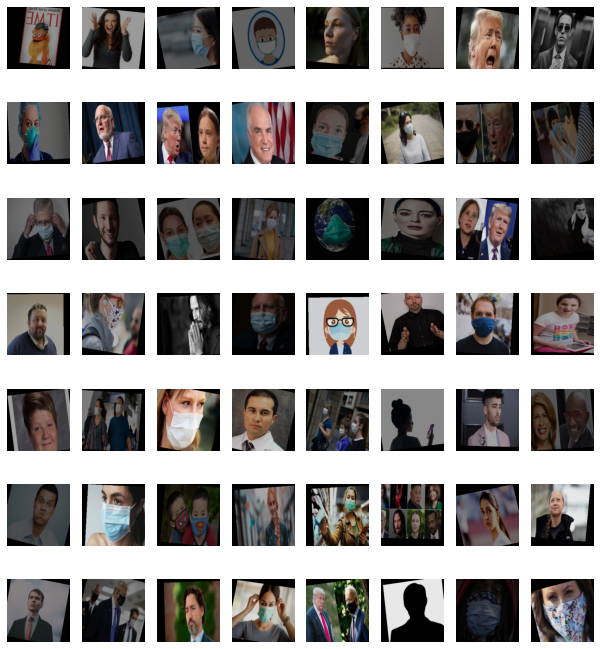

In [ ]:
#ImageDataGenerator generates indefinitely. Stop it after a desired number.
from itertools import islice as first

def generator_display(gen, batches=7):
    fig, ax = plt.subplots(nrows=batches, ncols=batch_size, figsize=(1.5*batches,1.5*gen.batch_size))
    
    for row in ax:
        for col in row:
            col.axis('off')
    for i, (x_batch, y_batch) in enumerate(first(gen,batches)):
        for j,(x,y) in enumerate(zip(x_batch,y_batch)):
            ax[i,j].imshow(x)
    
    plt.show()

generator_display(train_generator)

### VGG16 transfer learning

While we coud design manually the architecture, keras offers top performing models like the VGG16, with a very fine tuned architecture and weights resulting from training it to classify on the large *imagenet* dataset.

Even if it was originally trained for classifying objects among a large variety of classes different than ours, the feature space resulting from the convolutional layers output is extremely rich, so we build some dense layers on top of it and only train the dense layers weights on our dataset.

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam

# def VGG_binary(input_shape, classes):
def VGG_categorical(input_shape, classes):
    # Initialize VGG16 using pre-trained weights on imagenet and use transfer learning for re-training the last layers
    model = VGG16(weights='imagenet', include_top=False,input_shape=input_shape)
    # Freeze all the layers except for the last ones, so that we can retrain the last ones.
    for layer in model.layers[:-4]:
        layer.trainable = False
    # Adding our new layers    
    top_layers = model.output
    top_layers = Flatten(input_shape=model.output_shape[1:])(top_layers)
    top_layers = Dense(500, kernel_initializer='random_uniform', activation="relu")(top_layers)
    top_layers = Dropout(0.4)(top_layers)
    top_layers = Dense(50, kernel_initializer='random_uniform', activation="relu")(top_layers)
    top_layers = Dropout(0.3)(top_layers)
    top_layers = Dense(classes, activation="softmax")(top_layers)
    # top_layers = Dense(1, activation="sigmoid")(top_layers)
    
    # Add top layers on top of freezed (not re-trained) layers of VGG16
    model = Model(input = model.input, output = top_layers)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['binary_accuracy'])
    
    return model

model = VGG_categorical((target_size,target_size,channels),classes=2)

## Train

In [ ]:
model.fit_generator(train_generator,	
                    epochs=8,
                    verbose=1,
                    steps_per_epoch= train_step_size,
                    validation_data=valid_generator,
                    validation_steps=valid_step_size,
                   )

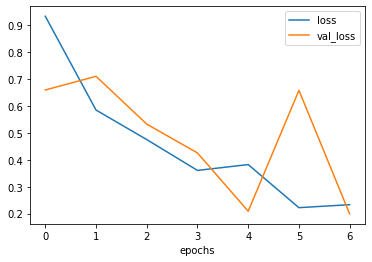

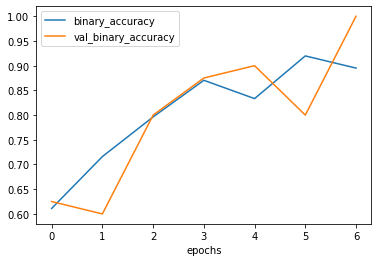

In [ ]:
def plot_learning_curve(model):
    """Display loss and metrics at each epoch of a keras model"""
    hist=pd.DataFrame(model.history.history)
    hist=hist.reset_index().rename({'index':'epochs'},axis='columns').set_index('epochs')
    for loss in model.metrics_names:
        hist[[loss,'val_'+loss]].plot();plt.show()

plot_learning_curve(model)

#Grad-CAM

Gradient-weighted Class Activation Mapping is really simple and produces the best results to display **attention maps** in my experience, and has been around for some years.

As the name suggests, it just takes the stack of filters of some convolutional layer deep in the neuronal network, that is, with **higly semantic content**, and takes a sum of the **activations** of each filter weighted by the **gradient** of the probability of a class with respect to it. This produces an image heatmap, which can be upscaled to the original image and blended.

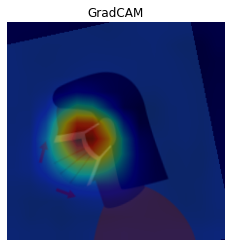

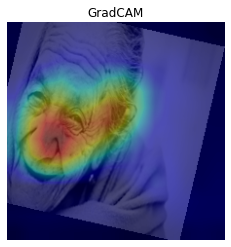

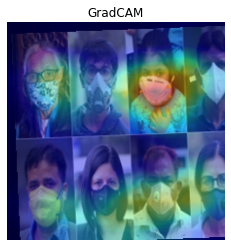

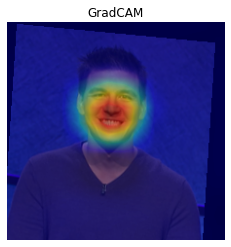

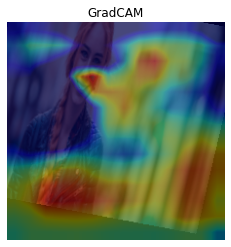

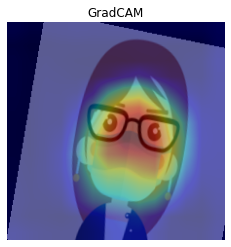

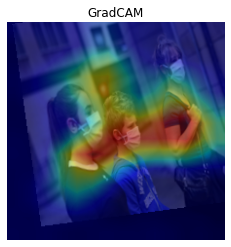

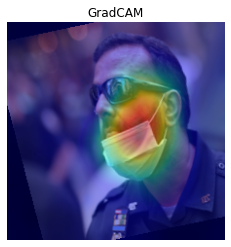

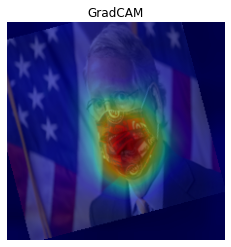

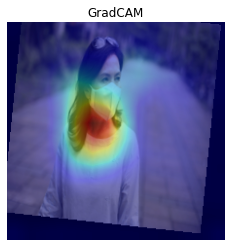

In [ ]:
from keras import backend as K
import cv2

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    class_score = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(class_score, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    activations, grads_val = gradient_function([image])
    activations, grads_val = activations[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(activations, weights)

    #Upsize
    cam = cv2.resize(cam, (target_size, target_size), cv2.INTER_LINEAR)
    #Draw only positive contributions
    cam = np.maximum(cam, 0)
    #Normalize values
    cam = cam / cam.max()
    return cam

def show_blend(img, cam):
    plt.title('GradCAM')
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(gradcam, cmap='jet', alpha=0.4)
    plt.show()

data_train = [(x,y) for batch_x,batch_y in first(train_generator,20) for x,y in zip(batch_x,batch_y)]
X_train = np.array([x for x,y in data_train])
Y_train = np.array([y for x,y in data_train])

for x,y in zip(X_train[:10], Y_train[:10]):
  gradcam = grad_cam(model, np.array([x]), cls=y, layer_name='block5_conv3')
  show_blend(x, gradcam)